# About

In the previous notebook, you learnt about the segmentation problem and explored the data. In this notebook, you will learn how Deep Learning, a form of Machine Learning, can be used to predict the tumor regions on the MRI scans similar to radiologists. To get you started, we have trained the state-of-the-art U-Net architecture to develop a model for segmenting tumor.

# Learning Objectives

> In this file, you will learn the following:
>    
><ol>
>  <li>The U-Net Architecture</li>
>  <li>History of the Pre-trained Model</li>
>  <li>Loading in Model Weights</li>
>  <li>Predicting on Test Dataset</li>
></ol>

## Imports

In [1]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib.util
import keras
import sys
import numpy as np
from sklearn.metrics import *
import seaborn as sns
from __main__ import *
import tensorflow as tf
# import tensorflow_io as tfio
# import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras 
# print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os
import sys
import importlib.util

2.9.1
Listing all GPU resources:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



In [2]:
from utils import *

2.9.1
Listing all GPU resources:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



## 1. The U-Net Architecture

The U-Net architecture consists of an encoder, decoder, and skip connections. Each module of the encoder consists of 2D Convolution layers, followed by Batch Normalization and MaxPooling layers. Four such modules make up the encoder. The decoder consists of four modules of Conv2DTranspose layers followed by Concatenate layers. The network performs slice-wise (2D) segmentation with multi-modal MRI scans provided as the input.

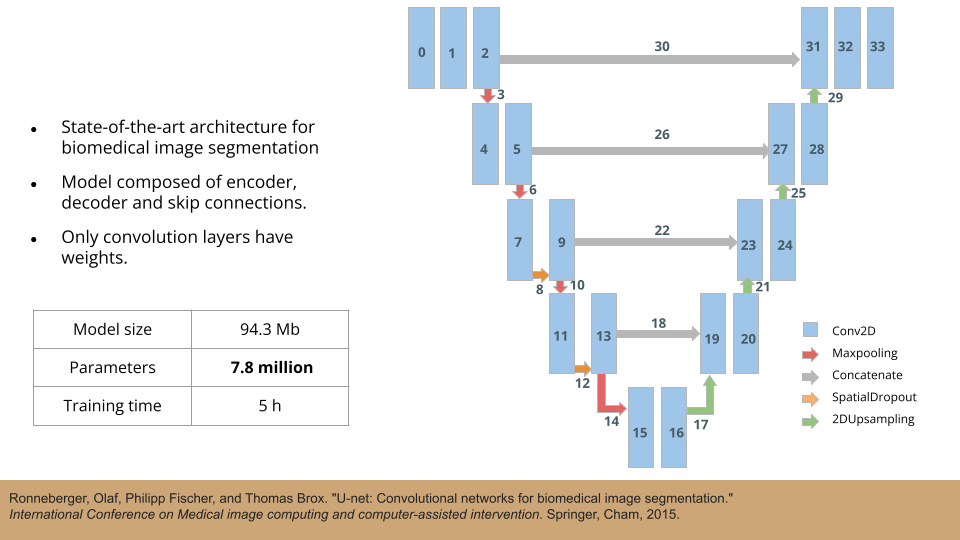

### Studying the model

In [3]:
#[QUESTION]:
#What are the dimensions of the model?
#What are the number of parameters in each layer of the model?

In [4]:
UNet = ModelLoader()
model = UNet.make_model()

/home/snehalbp/BDSI_2022_ML/BdsiEnv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2022-07-04 15:24:26.624624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 15:24:27.418328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10543 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7


Input size: (None, 144, 144, 4)
Output size: (None, 144, 144, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 144, 144, 4  0           []                               
                                )]                                                                
                                                                                                  
 encoder_1_a (Conv2D)           (None, 144, 144, 32  1184        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 encoder_1_b (Conv2D)           (None, 144, 144, 32  9248        ['encoder_1_a[0][0]']            
                            

                                )                                                                 
                                                                                                  
 decoder_1_b (Conv2D)           (None, 144, 144, 32  9248        ['decoder_1_a[0][0]']            
                                )                                                                 
                                                                                                  
 last_layer (Conv2D)            (None, 144, 144, 1)  33          ['decoder_1_b[0][0]']            
                                                                                                  
 activation (Activation)        (None, 144, 144, 1)  0           ['last_layer[0][0]']             
                                                                                                  
Total params: 7,848,865
Trainable params: 7,847,905
Non-trainable params: 960
_______________________________

## 2. History of the Pre-trained Model

Models were trained with Dice Loss function for 100 epochs on 8 GPUs. Adam optimizer (Kingma, 2015) was used with a learning rate of 1 × 10−4 and a batch size of 128. Data augmentation was used while training each of the models to improve generalization. This consisted of random rotations (0–25° degrees range), random zooming (value = 0.2, zooms image by 80–120% range), width shift (value = 0.2, horizontal translation of images by 0.2 percent), height shift (value = 0.2, vertical translation of images by 0.2 percent), shear (value = 0.2, clips the image in counter-clockwise direction) and random horizontal flips.

In [5]:
#Load the history.pkl file
history_dict = UNet.read_history()

In [6]:
history_dict.keys()

dict_keys(['loss', 'dice_coef', 'accuracy', 'mean_binary_crossentropy', 'soft_dice_coef', 'dice_coef_loss', 'val_loss', 'val_dice_coef', 'val_accuracy', 'val_mean_binary_crossentropy', 'val_soft_dice_coef', 'val_dice_coef_loss'])

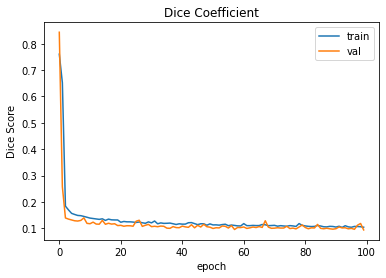

In [7]:
#Plot the training and validation curves of the trained model.
plt.plot(history_dict['dice_coef_loss'])
plt.plot(history_dict['val_dice_coef_loss'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [8]:
#[QUESTION]:
#Can you tell whether the model is trained well or not?

## 3. Loading in Model Weights

In [9]:
#Access the model weights:
W = model.get_weights()

In [10]:
len(W)

54

## 4. Predicting on Test Dataset

First, we will create a directory where we can store all our predictions:

In [11]:
# ! mkdir /scratch/bdsi_root/bdsi1/snehalbp/predictions

Next, we access patients in the test dataset one-by-one, use the model to predict tumor for these patients, and then save these in the prediction folder

In [5]:
MRIData = DataLoader()
patient = Patient(MRIData, UNet)

In [14]:
for case in MRIData.ptest:
    patient.create(case)  
    _,_, pred = patient.get_datafiles(pred=True)
    np.save(patient.prediction_path, pred)
    print("Saved {}".format(case))

2022-07-04 14:34:56.864739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


5/5 [==============================] - 3s 137ms/step
Saved TCGA-HT-A5RC
5/5 [==============================] - 0s 24ms/step
Saved TCGA-CS-4941
5/5 [==============================] - 0s 23ms/step
Saved TCGA-02-0060
5/5 [==============================] - 0s 23ms/step
Saved TCGA-12-1093
5/5 [==============================] - 0s 23ms/step
Saved TCGA-06-0241
5/5 [==============================] - 0s 23ms/step
Saved TCGA-DU-6410
5/5 [==============================] - 0s 23ms/step
Saved TCGA-HT-8107
5/5 [==============================] - 0s 22ms/step
Saved TCGA-DU-A6S6
5/5 [==============================] - 0s 23ms/step
Saved TCGA-HT-7616
5/5 [==============================] - 0s 23ms/step
Saved TCGA-FG-A6IZ
5/5 [==============================] - 0s 23ms/step
Saved TCGA-DU-A5TP
5/5 [==============================] - 0s 23ms/step
Saved TCGA-DU-6400
5/5 [==============================] - 0s 23ms/step
Saved TCGA-06-0168
5/5 [==============================] - 0s 23ms/step
Saved TCGA-08-0357
5/5 [

Now let's visualize model predictions for a particular patient:

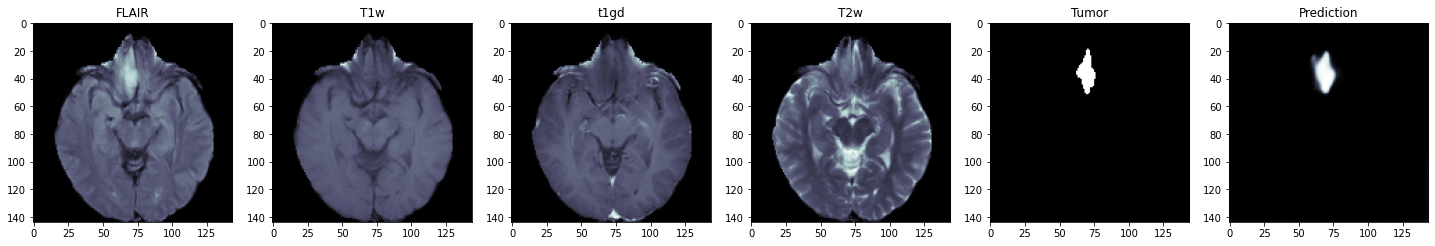

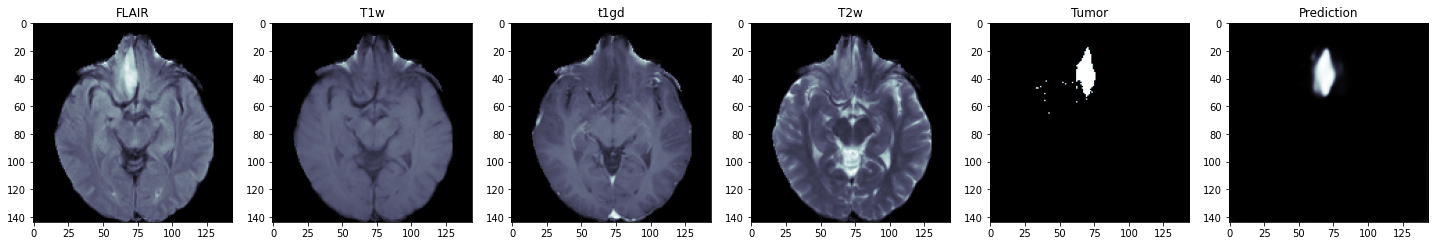

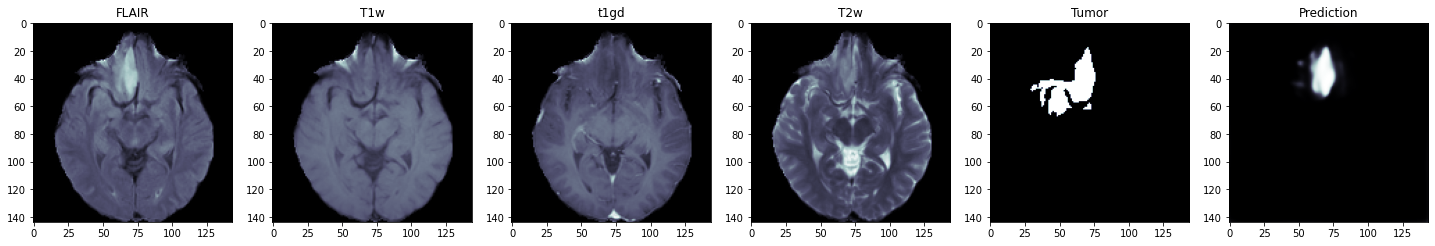

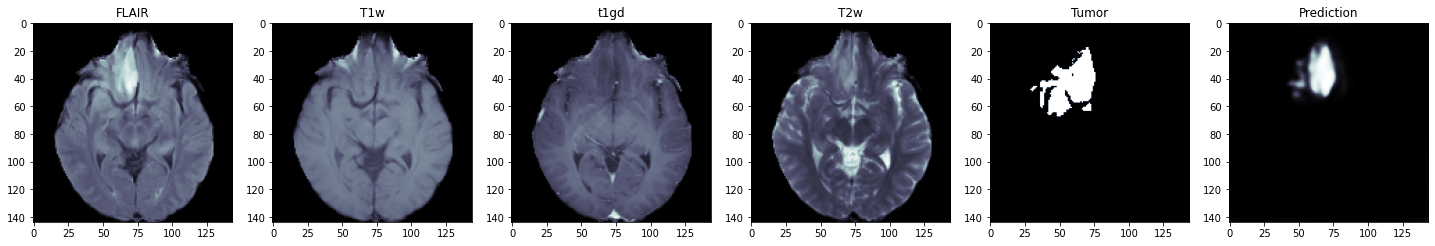

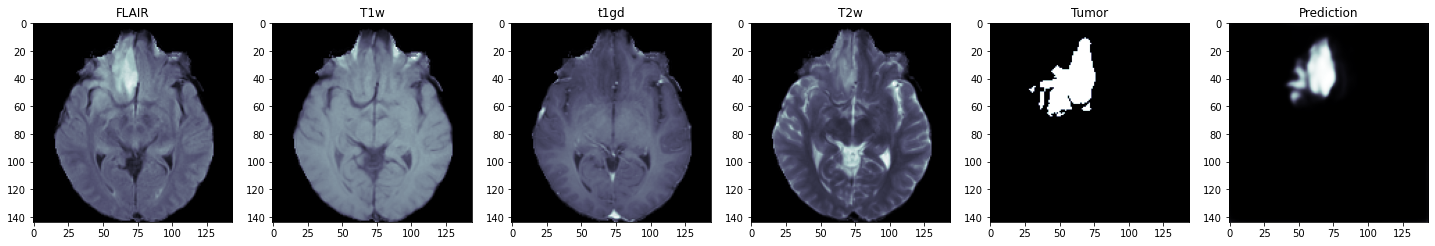

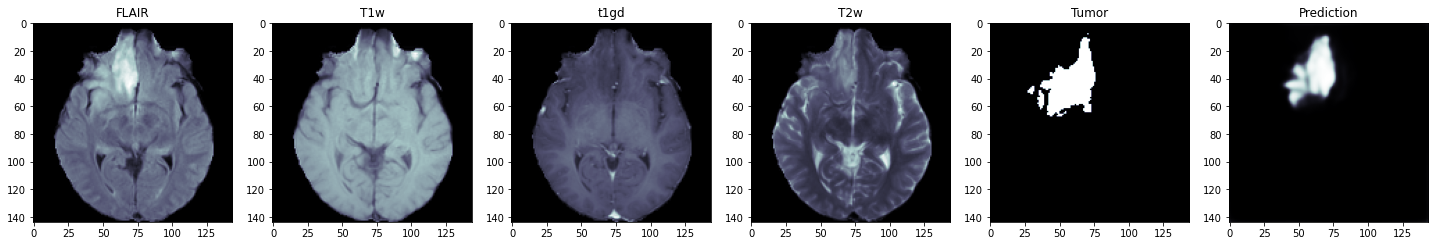

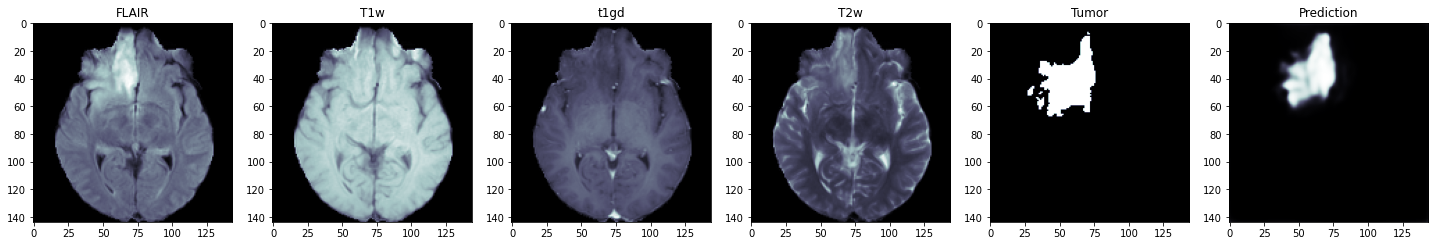

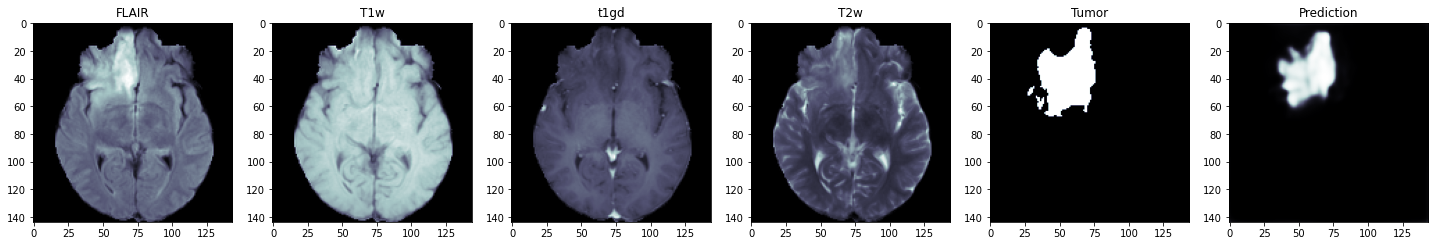

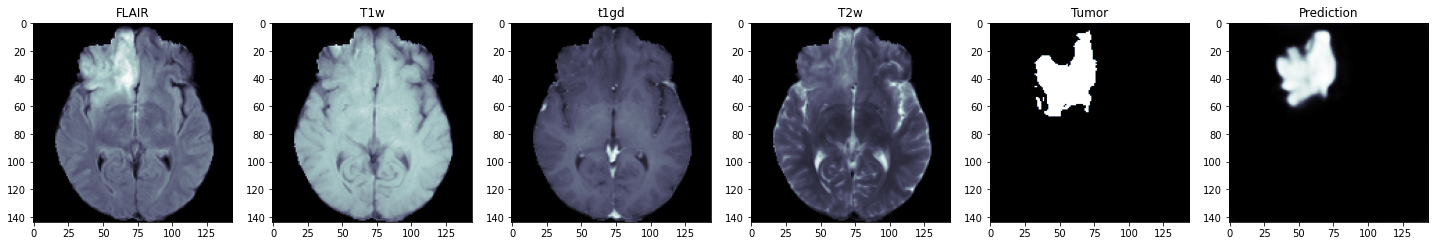

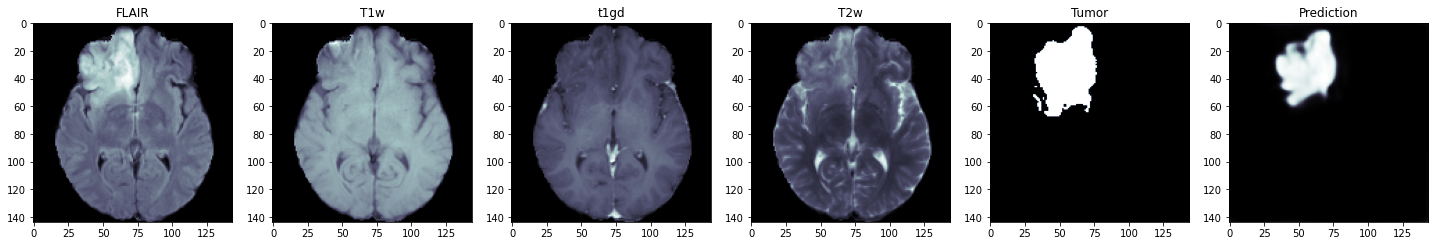

In [6]:
patient_case = 'TCGA-HT-7874'
patient.create(patient_case)
for z_slice in range(60,70):
    patient.plot_figures(z_slice)